# Sparkify Project - EMR Mode

This notebook contains code for the Capstopne project prepared for the Udacity Data Science Nanodegree.  
The scope of the project is to use Spark to analyse data coming from a fictious music streaming service ("Sparkify") in order to predict when a user is going to "churn" i.e. cancel from the service. This prediction would allow preventive actions (like, for example, promotion offers or bespoke recommendations).

In order to complete the project, the students were provided with a reduced dataset (128MB) that is used here for an analysis that can be conducted using Spark in local mode on a single machine, and with a full dataset  of ~12GB.  
This wersion of the notebook is intended to work on the latter, being deployed on a Spark cluster on EMR.

## Table of Contents

1. [Load libraries ad start Spark session](#Load-Libraries)<br>
2. [Load and Clean Dataset](#Load-and-Clean-Dataset)<br>
3. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
    3.1. [Time Spent/Number of Songs](#Time-Songs)<br>
    3.2. [Add a Friend/Thumbs Up/Down](#Friends-Thumbs)<br>
    3.3. [Submit an Upgrade/Downgrade request](#Upgrade-Downgrade)<br>
    3.4. [Roll Advert](#Roll-Advert)<br>
    3.5. [Demographics](#Demographics)<br>
    


## <a class="anchor" id="Load-Libraries">1. Load libraries</a>

In [1]:
from pyspark.sql import Window
from pyspark.sql import functions as F
from pyspark.sql.types import IntegerType, FloatType

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import re
import numpy as np
import math
import string

from datetime import datetime

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
1,application_1624545307399_0002,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [2]:
# Install matplotlib from given PyPI repository
# Ref.: https://aws.amazon.com/blogs/big-data/install-python-libraries-on-a-running-cluster-with-emr-notebooks/
sc.install_pypi_package("matplotlib", "https://pypi.org/simple") 

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  Using cached https://files.pythonhosted.org/packages/24/33/5568d443ba438d95d4db635dd69958056f087e57e1026bee56f959d53f9d/matplotlib-3.4.2-cp37-cp37m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/8a/bb/488841f56197b13700afd5658fc279a2025a39e22449b7cf29864669b15d/pyparsing-2.4.7-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/d4/70/d60450c3dd48ef87586924207ae8907090de0b306af2bce5d134d78615cb/python_dateutil-2.8.1-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/33/34/542152297dcc6c47a9dcb0685eac6d652d878ed3cea83bf2b23cb988e857/Pillow-8.2.0-cp37-cp37m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/f7/d2/e07d3ebb2bd7af696440ce7e754c59dd546ffe1bbe732c8ab68b9c834e61/cycler-0.10.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/d2/46/231de802ade4225b76b96cffe419cf3ce52bbe92e3b092cf12db7d11c207/kiwisolver-1.3.1-cp37-cp37m-manylinux1_x86_64.whl

In [3]:
# Uncomment to check installation
# sc.list_packages()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:
# Import pyplot
from matplotlib import pyplot as plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## <a class="anchor" id="Load-and-Clean-Dataset">2. Load and Clean Dataset</a>

In [5]:
# Load & Persist data
# Full dataset
path ="s3n://udacity-dsnd/sparkify/sparkify_event_data.json"
df_user_log = spark.read.json(path)
df_user_log.persist()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [6]:
# Check schema
df_user_log.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)

In [7]:
# Show the first row
df_user_log.head()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Row(artist='Popol Vuh', auth='Logged In', firstName='Shlok', gender='M', itemInSession=278, lastName='Johnson', length=524.32934, level='paid', location='Dallas-Fort Worth-Arlington, TX', method='PUT', page='NextSong', registration=1533734541000, sessionId=22683, song='Ich mache einen Spiegel - Dream Part 4', status=200, ts=1538352001000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='1749042')

In [8]:
# Check num of rows, columns
print('Number of rows in the dataset: ', df_user_log.count(), '; Number of columns: ', len(df_user_log.columns))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Number of rows in the dataset:  26259199 ; Number of columns:  18

To clean the dataset, we can delete eventual `NaN` in the `userId` and `sessionId` field, and take care of the cases of missing users also:

In [9]:
# Drop NaN
df_user_log_valid = df_user_log.dropna(how = "any", subset = ["userId", "sessionId"])
# Drop empty users
df_user_log_valid = df_user_log_valid.filter(df_user_log_valid["userId"] != "")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [10]:
# Check num of rows remaining
print('Num. of rows in the valid dataset: ', df_user_log_valid.count())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Num. of rows in the valid dataset:  26259199

## <a class="anchor" id="Exploratory-Data-Analysis">3. Exploratory Data Analysis</a>

In this phase we'll mainly look at the data and try to get familiar with it, to see what kind of trends or interesting information might be available afterwards to work on feature engineering.

A cell that seems to provide quite a bit of useful information is `page`, that documents the various pages visited by the users:

In [11]:
# Check available pages
df_user_log.select("page").dropDuplicates().sort("page").show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|               Login|
|              Logout|
|            NextSong|
|            Register|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
| Submit Registration|
|      Submit Upgrade|
|         Thumbs Down|
+--------------------+
only showing top 20 rows

Based on the type of information available in this column, we can define new variables identifying, for example, an actual churn (looking at when the users visits `Cancellation Confirmation`) or an Upgrade/Downgrade, but also events like the user giving a Thumbs Up or adding friends, or seeing a Rolling Advert.  
We can also recontruct the time spent by the users with the system, making reference to the `registration` and `ts` columns.

In [12]:
# Defining a churn variable based on the Cancellation Confirmation page
cancellation = F.udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())  
df_user_log_valid = df_user_log_valid.withColumn("churn", cancellation("page"))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [13]:
# Defining a sub_dwg variable based on the Submit Downgrade page
submit_dwg = F.udf(lambda x: 1 if x == "Submit Downgrade" else 0, IntegerType())
df_user_log_valid = df_user_log_valid.withColumn("sub_dwg", submit_dwg("page"))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [14]:
# Defining a sub_upg variable based on the Submit Upgrade page
submit_dwg = F.udf(lambda x: 1 if x == "Submit Upgrade" else 0, IntegerType())
df_user_log_valid = df_user_log_valid.withColumn("sub_upg", submit_dwg("page"))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [15]:
# Getting UNIX time from miliseconds to seconds
df_user_log_valid = df_user_log_valid.withColumn("ts", df_user_log_valid.ts/1000)                        
df_user_log_valid = df_user_log_valid.withColumn("registration", df_user_log_valid.registration/1000)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [16]:
# Defining a first_ts/last_ts variable showing the timestamp of the first/last entry 
# (Can be used to filter with time, will be used to calculate total duration of the permanence)
window = Window.partitionBy("userId")
df_user_log_valid = df_user_log_valid.withColumn("first_ts", F.min("ts").over(window))
df_user_log_valid = df_user_log_valid.withColumn("last_ts", F.max("ts").over(window))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [17]:
# Defining a perm_days variable showing the (rounded) number of days a user has spent with the service so far
df_user_log_valid = df_user_log_valid.withColumn("perm_days", \
                                                 F.round((df_user_log_valid.last_ts - df_user_log_valid.registration)\
                                                 /(3600*24)))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [18]:
# Defining a data_days variable showing the (rounded) number of days of data available for a user
df_user_log_valid = df_user_log_valid.withColumn("data_days", \
                                                 F.round((df_user_log_valid.last_ts - df_user_log_valid.first_ts)\
                                                 /(3600*24)))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [19]:
# Defining a roll_adv variable based on the Roll Advert page
roll_adv = F.udf(lambda x: 1 if x == "Roll Advert" else 0, IntegerType())  
df_user_log_valid = df_user_log_valid.withColumn("roll_adv", roll_adv("page"))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [20]:
# Defining a total_rolled_advert variable showing the total of the rolled advert events
# (We reuse the window defined previously, grouping by users)
df_user_log_valid= df_user_log_valid.withColumn("total_roll_adv", F.sum("roll_adv").over(window))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [21]:
# Defining an add_friend variable based on the Add Friend page
add_friend = F.udf(lambda x: 1 if x == "Add Friend" else 0, IntegerType())  
df_user_log_valid = df_user_log_valid.withColumn("add_friend", add_friend("page"))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [22]:
# Defining a total_add_friend variable showing the total of the friends added
# (We reuse the window defined previously, grouping by users)
df_user_log_valid= df_user_log_valid.withColumn("total_add_friend", F.sum("add_friend").over(window))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [23]:
# Defining a thumbs_up variable based on the Thumbs Up page
thumbs_up = F.udf(lambda x: 1 if x == "Thumbs Up" else 0, IntegerType())  
df_user_log_valid = df_user_log_valid.withColumn("thumbs_up", thumbs_up("page"))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [24]:
# Defining a total_thumbs_up variable showing the total of the Thumbs Up given
# (We reuse the window defined previously, grouping by users)
df_user_log_valid= df_user_log_valid.withColumn("total_thumbs_up", F.sum("thumbs_up").over(window))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [25]:
# Defining a thumbs_dwm variable based on the Thumbs Down page
thumbs_dwn = F.udf(lambda x: 1 if x == "Thumbs Down" else 0, IntegerType())  
df_user_log_valid = df_user_log_valid.withColumn("thumbs_dwn", thumbs_dwn("page"))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [26]:
# Defining a total_thumbs_dwn variable showing the total of the Thumbs Down given
# (We reuse the window defined previously, grouping by users)
df_user_log_valid= df_user_log_valid.withColumn("total_thumbs_dwn", F.sum("thumbs_dwn").over(window))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [27]:
# Check columns
df_user_log_valid.head()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Row(artist='Linkin Park', auth='Logged In', firstName='Nathan', gender='M', itemInSession=0, lastName='King', length=233.1424, level='paid', location='Lima, OH', method='PUT', page='NextSong', registration=1538251620.0, sessionId=10054, song='Hands Held High (Album Version)', status=200, ts=1539703092.0, userAgent='"Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='1001393', churn=0, sub_dwg=0, sub_upg=0, first_ts=1538365753.0, last_ts=1543425515.0, perm_days=60.0, data_days=59.0, roll_adv=0, total_roll_adv=0, add_friend=0, total_add_friend=11, thumbs_up=0, total_thumbs_up=43, thumbs_dwn=0, total_thumbs_dwn=6)

To gain significance, we can focus the analysis on users that have at least some history with the system, for example at least a week of data

In [28]:
# We can remove from the dataframe users that have less than a week of data
df_user_log_valid = df_user_log_valid.filter(df_user_log_valid.data_days >= 7)       

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [29]:
# Check num of rows remaining
print('Num. of rows in the filtered dataset: ', df_user_log_valid.count())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Num. of rows in the filtered dataset:  25989727

We can build now two datasets, one with the users that left vs. the other with the users that are staying:

In [30]:
# Create a list of users that cancelled vs. users that stayed
users_cancelled = df_user_log_valid.select(["userId"]).where(df_user_log_valid.churn == 1).dropDuplicates().collect()
users_staying = df_user_log_valid.select(["userId"]).where(df_user_log_valid.churn == 0).dropDuplicates().collect()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [31]:
# Check num of users in both datasets
print('Num. of users that left: ', len(users_cancelled), \
      '; Num. of users that are staying: ', len(users_staying))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Num. of users that left:  3971 ; Num. of users that are staying:  20304

In [32]:
# Select a subset of the dataframe with the users that left
users_cancelled_list = [us_c[0] for us_c in users_cancelled]
df_user_log_cancelled = df_user_log_valid.filter(df_user_log_valid.userId.isin(users_cancelled_list))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [33]:
# Select a subset of the dataframe with the users that stayed
users_staying_list = [us_s[0] for us_s in users_staying]
df_user_log_staying = df_user_log_valid.filter(df_user_log_valid.userId.isin(users_staying_list))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [34]:
# Check the size of the datasets
print('Num. of rows in the dataset of users that cancelled: ', df_user_log_cancelled.count())
print('Num. of rows in the dataset of users that are staying: ', df_user_log_staying.count())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Num. of rows in the dataset of users that cancelled:  5192153
Num. of rows in the dataset of users that are staying:  25989727

We can further refine, building datasets focusing on the last week of activity for the users, so to see wether or not there's a change for the users that churn as they approach the moment they would leave:

In [35]:
# Select last week of users that cancelled
df_user_log_cancelled_lweek = df_user_log_cancelled.filter((df_user_log_cancelled.last_ts - df_user_log_valid.ts) < \
                                                      (3600*24*7))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [36]:
# Select last week of users that stay
df_user_log_staying_lweek = df_user_log_staying.filter((df_user_log_staying.last_ts - df_user_log_valid.ts) < \
                                                      (3600*24*7))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [37]:
# Check the size of the datasets
print('Num. of rows in the dataset of users that cancelled - last week data: ', df_user_log_cancelled_lweek.count())
print('Num. of rows in the dataset of users that are staying - last week data: ', df_user_log_staying_lweek.count())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Num. of rows in the dataset of users that cancelled - last week data:  1488643
Num. of rows in the dataset of users that are staying - last week data:  5230636

In [38]:
# Create a list of users that cancelled vs. users that stayed in the last week
users_cancelled_lweek = df_user_log_cancelled_lweek.select(["userId"]).dropDuplicates().collect()
users_staying_lweek = df_user_log_staying_lweek.select(["userId"]).dropDuplicates().collect()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [39]:
# Check num of users in both datasets
print('Num. of users that left - last week data: ', len(users_cancelled_lweek), \
      '; Num. of users that are staying - last week data: ', len(users_staying_lweek))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Num. of users that left - last week data:  3971 ; Num. of users that are staying - last week data:  20304

### <a class="anchor" id="Time-Songs">3.1. Time spent/Number of Songs</a>

As a first step, we can look at the amount of time spent with the service and at the number of songs listened in a day, comparing the users that cancelled and those that are staying, both looking at the whole dataset and at the last week only.

In [40]:
# Select, for every user that cancelled, the number of songs, the time they spent with the service and the time
# window of tha analysis
song_time_canc = df_user_log_cancelled.\
                filter(df_user_log_cancelled["song"] != "").\
                groupBy("userId").\
                agg(F.max("perm_days"), F.max("data_days"), F.countDistinct("song")).\
                collect()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [41]:
# Get the time 
delta_time_cancelled = [song_time[1] for song_time in song_time_canc]
# Get the number of songs listened per day day (on average)
num_songs_cancelled = [song_time[3]/song_time[2] for song_time in song_time_canc]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [42]:
# Select, for every user that stays, the number of songs, the time they spent with the service and the time
# window of tha analysis
song_time_stay = df_user_log_staying.\
                filter(df_user_log_staying["song"] != "").\
                groupBy("userId").\
                agg(F.max("perm_days"), F.max("data_days"), F.countDistinct("song")).\
                collect()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [43]:
# Get the time
delta_time_staying = [song_time[1] for song_time in song_time_stay]
# Get the number of songs listened per day day (on average)
num_songs_staying = [song_time[3]/song_time[2] for song_time in song_time_stay]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

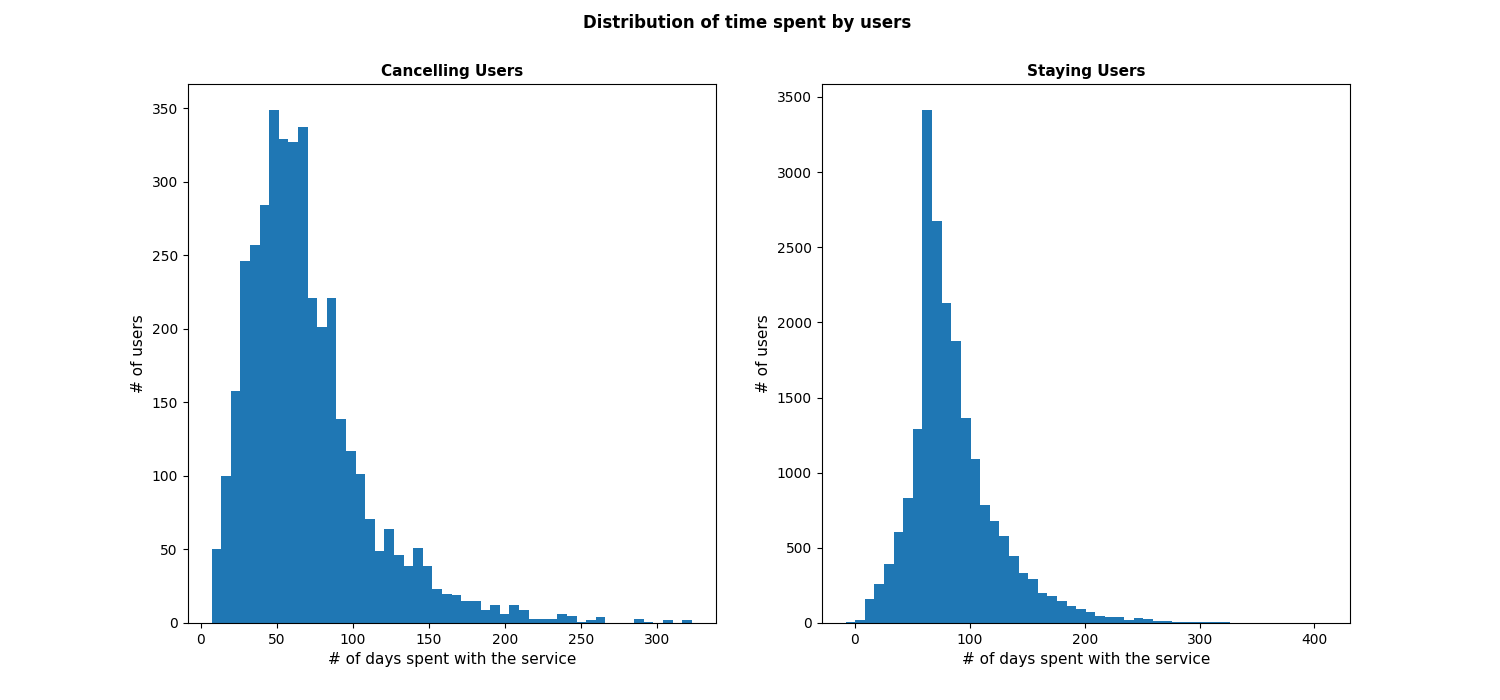

In [44]:
# Plot histogram for time
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.suptitle('Distribution of time spent by users ', fontsize=12, fontweight='bold')
fig.set_figheight(7) 
fig.set_figwidth(15)

ax1.hist(delta_time_cancelled, bins=50)
ax1.set_xlabel('# of days spent with the service', fontsize=11)
ax1.set_ylabel('# of users', fontsize=11)
ax1.set_title('Cancelling Users', fontsize=11,fontweight='bold')

ax2.hist(delta_time_staying, bins=50)
ax2.set_xlabel('# of days spent with the service', fontsize=11)
ax2.set_ylabel('# of users', fontsize=11)
ax2.set_title('Staying Users', fontsize=11,fontweight='bold');

%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

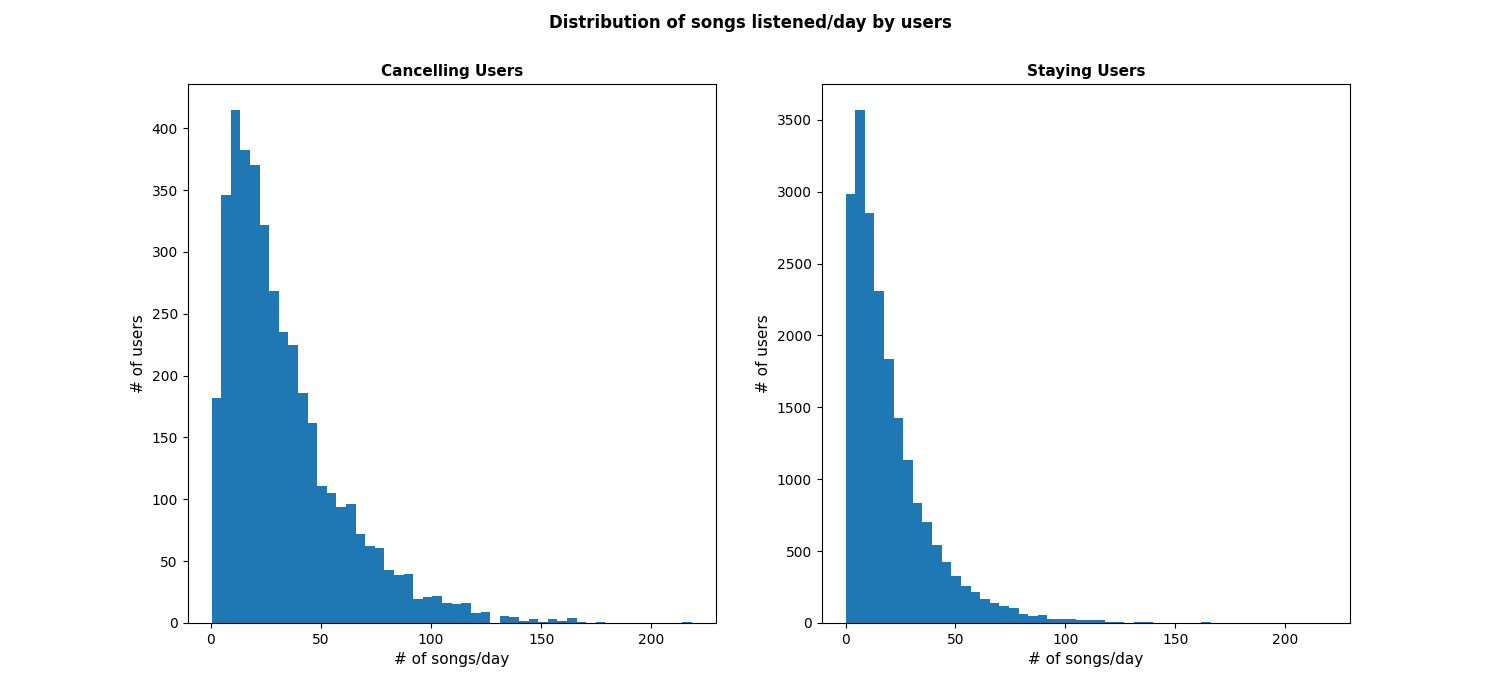

In [45]:
# Plot histogram for songs
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.suptitle('Distribution of songs listened/day by users', fontsize=12, fontweight='bold')
fig.set_figheight(7) 
fig.set_figwidth(15)

ax1.hist(num_songs_cancelled, bins=50)
ax1.set_xlabel('# of songs/day', fontsize=11)
ax1.set_ylabel('# of users', fontsize=11)
ax1.set_title('Cancelling Users', fontsize=11,fontweight='bold')

ax2.hist(num_songs_staying, bins=50)
ax2.set_xlabel('# of songs/day', fontsize=11)
ax2.set_ylabel('# of users', fontsize=11)
ax2.set_title('Staying Users', fontsize=11,fontweight='bold');

%matplot plt

In [46]:
# Look at the statistics
stats_song_canc = spark.createDataFrame(num_songs_cancelled, FloatType()).describe().collect()
stats_song_stay = spark.createDataFrame(num_songs_staying, FloatType()).describe().collect()

print('---------------------------------------------------')
print('Songs per day statistics for users that cancelled:')
print('Mean = ', '{:.2f}'.format(float(stats_song_canc[1][1])), \
      '; Std. Dev. = ',  '{:.2f}'.format(float(stats_song_canc[2][1])))
print('---------------------------------------------------')
print('Songs per day statistics for users that stay:')
print('Mean = ', '{:.2f}'.format(float(stats_song_stay[1][1])), \
      '; Std. Dev. = ',  '{:.2f}'.format(float(stats_song_stay[2][1])))
print('---------------------------------------------------')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

---------------------------------------------------
Songs per day statistics for users that cancelled:
Mean =  33.40 ; Std. Dev. =  26.71
---------------------------------------------------
Songs per day statistics for users that stay:
Mean =  20.21 ; Std. Dev. =  19.17
---------------------------------------------------

We can see if anything changes in the last week of permanence:

In [47]:
# Select, for every user that cancelled, the number of songs they listened in the last week
song_time_canc_lweek = df_user_log_cancelled_lweek.\
                filter(df_user_log_cancelled_lweek["song"] != "").\
                groupBy("userId").\
                agg(F.countDistinct("song")).\
                collect()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [48]:
# Get the number of songs listened per day (on average)
num_songs_cancelled_lweek = [song_time[1]/7 for song_time in song_time_canc_lweek]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [49]:
# Select, for every user that stays, the number of songs they listened in the last week
song_time_stay_lweek = df_user_log_staying_lweek.\
                filter(df_user_log_staying_lweek["song"] != "").\
                groupBy("userId").\
                agg(F.countDistinct("song")).\
                collect()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [50]:
# Get the number of songs listened per day (on average)
num_songs_staying_lweek = [song_time[1]/7 for song_time in song_time_stay_lweek]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

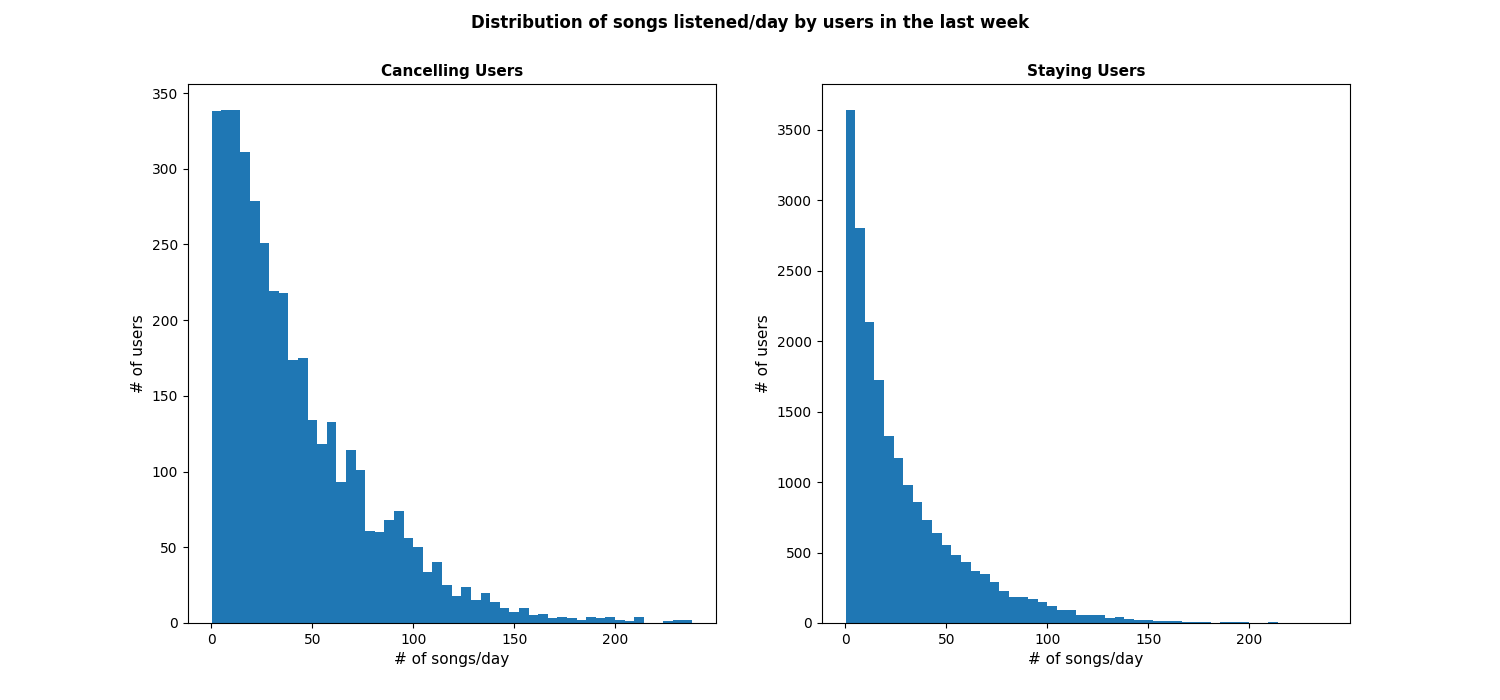

In [51]:
# Plot histogram for songs
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.suptitle('Distribution of songs listened/day by users in the last week', fontsize=12, fontweight='bold')
fig.set_figheight(7) 
fig.set_figwidth(15)

ax1.hist(num_songs_cancelled_lweek, bins=50)
ax1.set_xlabel('# of songs/day', fontsize=11)
ax1.set_ylabel('# of users', fontsize=11)
ax1.set_title('Cancelling Users', fontsize=11,fontweight='bold')

ax2.hist(num_songs_staying_lweek, bins=50)
ax2.set_xlabel('# of songs/day', fontsize=11)
ax2.set_ylabel('# of users', fontsize=11)
ax2.set_title('Staying Users', fontsize=11,fontweight='bold');

%matplot plt

In [52]:
# Look at the statistics
stats_song_canc_lweek = spark.createDataFrame(num_songs_cancelled_lweek, FloatType()).describe().collect()
stats_song_stay_lweek = spark.createDataFrame(num_songs_staying_lweek, FloatType()).describe().collect()

print('--------------------------------------------------------------')
print('Songs per day statistics for users that cancelled - last week:')
print('Mean = ', '{:.2f}'.format(float(stats_song_canc_lweek[1][1])), \
      '; Std. Dev. = ',  '{:.2f}'.format(float(stats_song_canc_lweek[2][1])))
print('--------------------------------------------------------------')
print('Songs per day statistics for users that stay - last week:')
print('Mean = ', '{:.2f}'.format(float(stats_song_stay_lweek[1][1])), \
      '; Std. Dev. = ',  '{:.2f}'.format(float(stats_song_stay_lweek[2][1])))
print('--------------------------------------------------------------')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

--------------------------------------------------------------
Songs per day statistics for users that cancelled - last week:
Mean =  41.80 ; Std. Dev. =  36.71
--------------------------------------------------------------
Songs per day statistics for users that stay - last week:
Mean =  28.86 ; Std. Dev. =  29.95
--------------------------------------------------------------

### <a class="anchor" id="Friends-Thumbs">3.2. Add a Friend/Thumbs Up/Down</a>

As another area of interest, we could look into how do the users interact with the service, inviting friends or expressing preferences on songs.

#### 3.2.1. Add a friend

In [53]:
# Select, for every user that cancelled, the number of added friends and the time window of the analysis
added_friend_canc = df_user_log_cancelled.\
                groupBy("userId").\
                agg(F.max("data_days"), F.max("total_add_friend")).collect()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [54]:
# Get the number of friends added per day, on average
added_friend_day_canc = [added_friend[2]/added_friend[1] for added_friend in added_friend_canc]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [55]:
# Select, for every user that is staying, the number of added friends and the time window of the analysis
added_friend_stay = df_user_log_staying.\
                groupBy("userId").\
                agg(F.max("data_days"), F.max("total_add_friend")).collect()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [56]:
# Get the number of friends added per day, on average
added_friend_day_stay = [added_friend[2]/added_friend[1] for added_friend in added_friend_stay]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

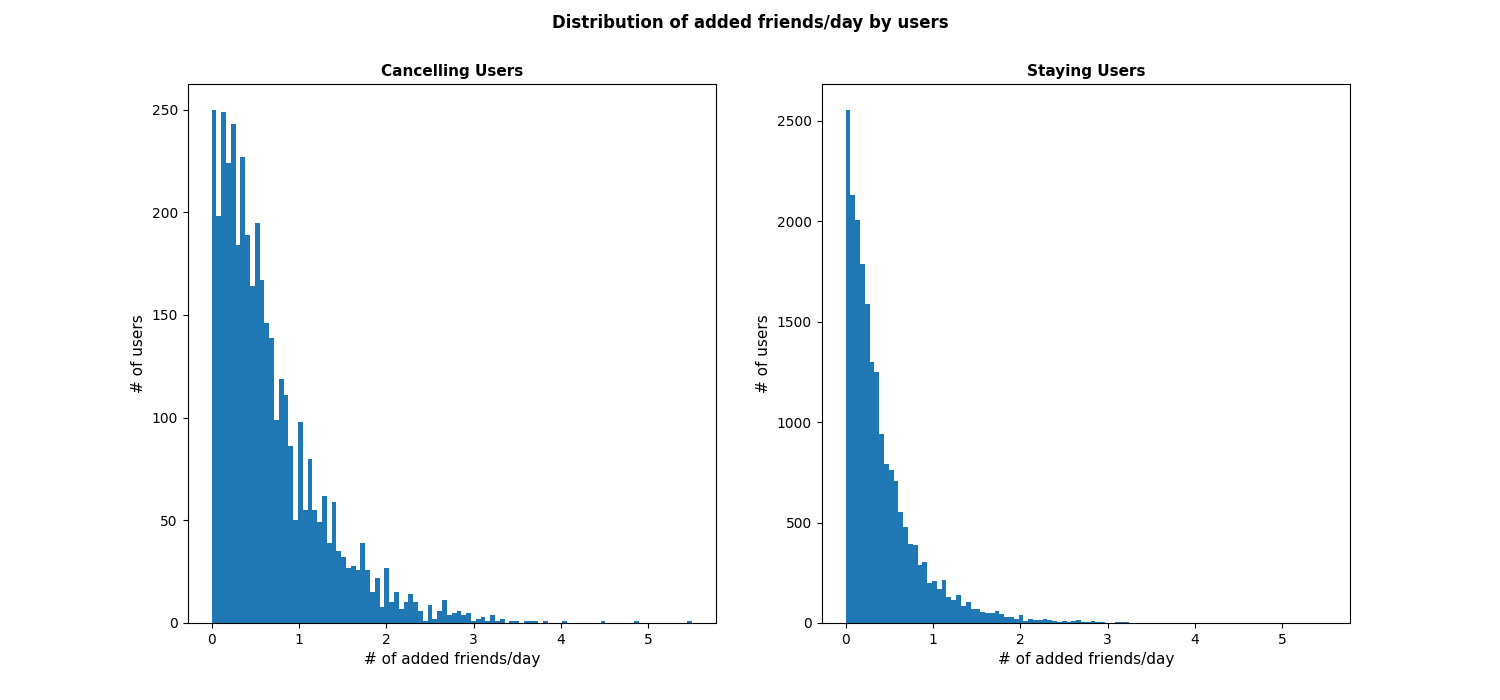

In [57]:
# Plot histogram for added friends
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.suptitle('Distribution of added friends/day by users', fontsize=12, fontweight='bold')
fig.set_figheight(7) 
fig.set_figwidth(15)

ax1.hist(added_friend_day_canc, bins=100)
ax1.set_xlabel('# of added friends/day', fontsize=11)
ax1.set_ylabel('# of users', fontsize=11)
ax1.set_title('Cancelling Users', fontsize=11,fontweight='bold')

ax2.hist(added_friend_day_stay, bins=100)
ax2.set_xlabel('# of added friends/day', fontsize=11)
ax2.set_ylabel('# of users', fontsize=11)
ax2.set_title('Staying Users', fontsize=11,fontweight='bold');

%matplot plt

In [58]:
# Look at the statistics
stats_added_friend_canc = spark.createDataFrame(added_friend_day_canc, FloatType()).describe().collect()
stats_added_friend_stay = spark.createDataFrame(added_friend_day_stay, FloatType()).describe().collect()

print('---------------------------------------------------------')
print('Added friend per day statistics for users that cancelled:')
print('Mean = ', '{:.2f}'.format(float(stats_added_friend_canc[1][1])), \
      '; Std. Dev. = ',  '{:.2f}'.format(float(stats_added_friend_canc[2][1])))
print('---------------------------------------------------------')
print('Added friend per day statistics for users that stay:')
print('Mean = ', '{:.2f}'.format(float(stats_added_friend_stay[1][1])), \
      '; Std. Dev. = ',  '{:.2f}'.format(float(stats_added_friend_stay[2][1])))
print('---------------------------------------------------------')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

---------------------------------------------------------
Added friend per day statistics for users that cancelled:
Mean =  0.68 ; Std. Dev. =  0.61
---------------------------------------------------------
Added friend per day statistics for users that stay:
Mean =  0.41 ; Std. Dev. =  0.44
---------------------------------------------------------

We can check if anything changes during last week:

In [59]:
# Select, for every user that cancelled, the number of added friends in the last week
added_friend_canc_lweek = df_user_log_cancelled_lweek.\
                groupBy("userId").\
                agg(F.sum("add_friend")).collect()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [60]:
# Get the number of friends added per day, on average
added_friend_day_canc_lweek = [added_friend[1]/7 for added_friend in added_friend_canc_lweek]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [61]:
# Select, for every user that is staying, the number of added friends in the last week
added_friend_stay_lweek = df_user_log_staying_lweek.\
                groupBy("userId").\
                agg(F.sum("add_friend")).collect()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [62]:
# Get the number of friends added per day, on average
added_friend_day_stay_lweek = [added_friend[1]/7 for added_friend in added_friend_stay_lweek]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

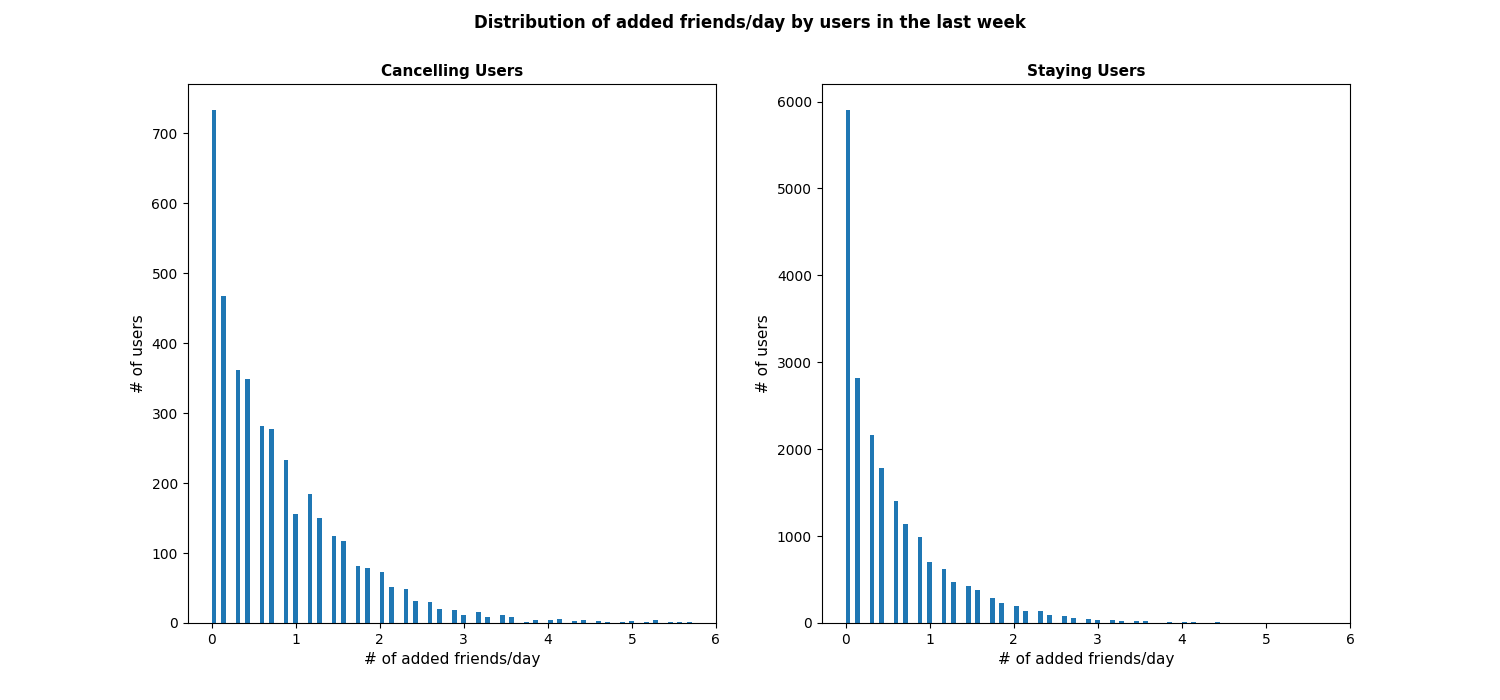

In [63]:
# Plot histogram for added friends
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.suptitle('Distribution of added friends/day by users in the last week', fontsize=12, fontweight='bold')
fig.set_figheight(7) 
fig.set_figwidth(15)

ax1.hist(added_friend_day_canc_lweek, bins=100)
ax1.set_xlabel('# of added friends/day', fontsize=11)
ax1.set_ylabel('# of users', fontsize=11)
ax1.set_title('Cancelling Users', fontsize=11,fontweight='bold')

ax2.hist(added_friend_day_stay_lweek, bins=100)
ax2.set_xlabel('# of added friends/day', fontsize=11)
ax2.set_ylabel('# of users', fontsize=11)
ax2.set_title('Staying Users', fontsize=11,fontweight='bold');

%matplot plt

In [64]:
# Look at the statistics
stats_added_friend_canc_lweek = spark.createDataFrame(added_friend_day_canc_lweek, FloatType()).describe().collect()
stats_added_friend_stay_lweek = spark.createDataFrame(added_friend_day_stay_lweek, FloatType()).describe().collect()

print('---------------------------------------------------------------------')
print('Added friend per day statistics for users that cancelled - last week:')
print('Mean = ', '{:.2f}'.format(float(stats_added_friend_canc_lweek[1][1])), \
      '; Std. Dev. = ',  '{:.2f}'.format(float(stats_added_friend_canc_lweek[2][1])))
print('---------------------------------------------------------------------')
print('Added friend per day statistics for users that stay - last week:')
print('Mean = ', '{:.2f}'.format(float(stats_added_friend_stay_lweek[1][1])), \
      '; Std. Dev. = ',  '{:.2f}'.format(float(stats_added_friend_stay_lweek[2][1])))
print('---------------------------------------------------------------------')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

---------------------------------------------------------------------
Added friend per day statistics for users that cancelled - last week:
Mean =  0.78 ; Std. Dev. =  0.83
---------------------------------------------------------------------
Added friend per day statistics for users that stay - last week:
Mean =  0.54 ; Std. Dev. =  0.67
---------------------------------------------------------------------

#### 3.2.2. Thumbs up

In [65]:
# Select, for every user that cancelled, the number of thumbs up given and the time window of the analysis
thumbs_up_canc = df_user_log_cancelled.\
                groupBy("userId").\
                agg(F.max("data_days"), F.max("total_thumbs_up")).collect()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [66]:
# Get the number of thumbs up given, on average
thumbs_up_day_canc = [thumbs_given[2]/thumbs_given[1] for thumbs_given in thumbs_up_canc]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [67]:
# Select, for every user that is staying, the number of thumbs up given and the time window of the analysis
thumbs_up_stay = df_user_log_staying.\
                groupBy("userId").\
                agg(F.max("data_days"), F.max("total_thumbs_up")).collect()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [68]:
# Get the number of thumbs up given, on average
thumbs_up_day_stay = [thumbs_given[2]/thumbs_given[1] for thumbs_given in thumbs_up_stay]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

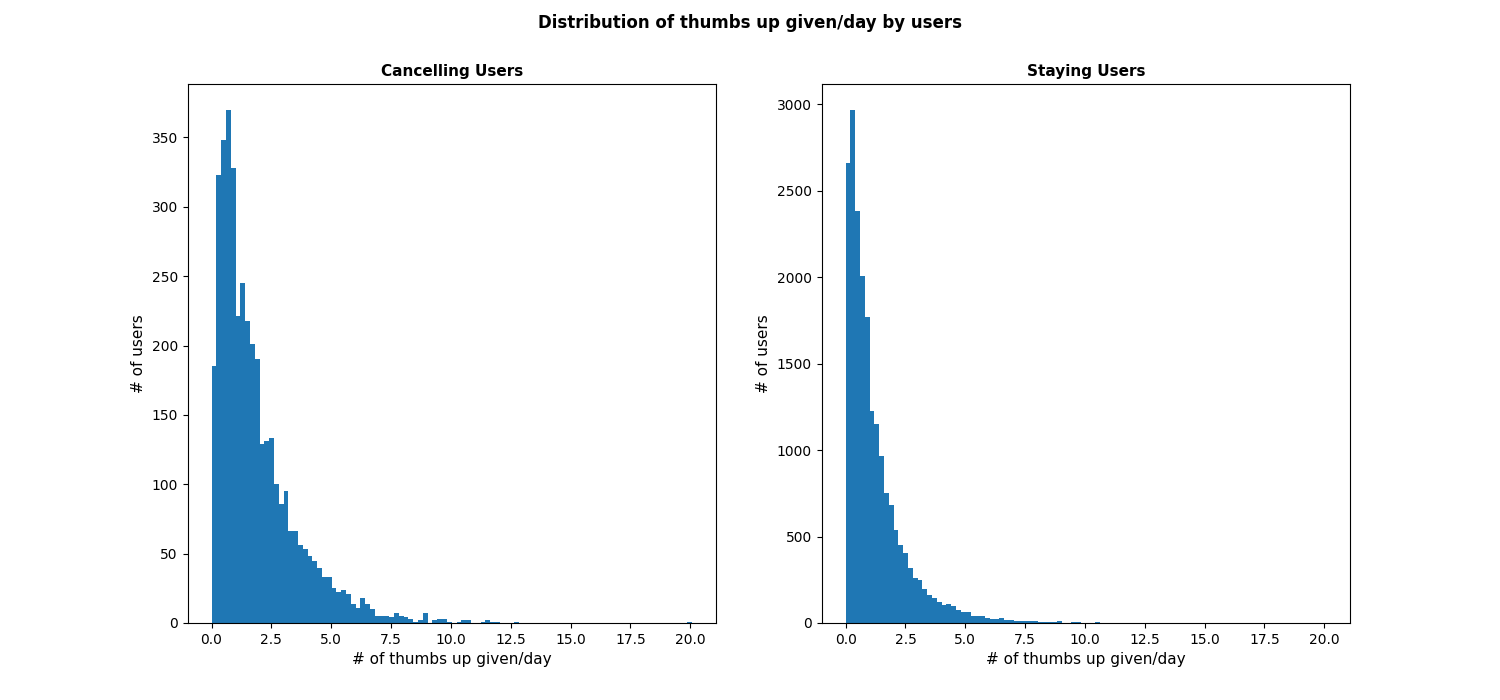

In [69]:
# Plot histogram for thumbs up
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.suptitle('Distribution of thumbs up given/day by users', fontsize=12, fontweight='bold')
fig.set_figheight(7) 
fig.set_figwidth(15)

ax1.hist(thumbs_up_day_canc, bins=100)
ax1.set_xlabel('# of thumbs up given/day', fontsize=11)
ax1.set_ylabel('# of users', fontsize=11)
ax1.set_title('Cancelling Users', fontsize=11,fontweight='bold')

ax2.hist(thumbs_up_day_stay, bins=100)
ax2.set_xlabel('# of thumbs up given/day', fontsize=11)
ax2.set_ylabel('# of users', fontsize=11)
ax2.set_title('Staying Users', fontsize=11,fontweight='bold');

%matplot plt

In [70]:
# Look at the statistics
stats_thumbs_up_canc = spark.createDataFrame(thumbs_up_day_canc, FloatType()).describe().collect()
stats_thumbs_up_stay = spark.createDataFrame(thumbs_up_day_stay, FloatType()).describe().collect()

print('------------------------------------------------------------')
print('Thumbs up given per day statistics for users that cancelled:')
print('Mean = ', '{:.2f}'.format(float(stats_thumbs_up_canc[1][1])), \
      '; Std. Dev. = ',  '{:.2f}'.format(float(stats_thumbs_up_canc[2][1])))
print('------------------------------------------------------------')
print('Thumbs up given per day statistics for users that stay:')
print('Mean = ', '{:.2f}'.format(float(stats_thumbs_up_stay[1][1])), \
      '; Std. Dev. = ',  '{:.2f}'.format(float(stats_thumbs_up_stay[2][1])))
print('------------------------------------------------------------')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

------------------------------------------------------------
Thumbs up given per day statistics for users that cancelled:
Mean =  1.88 ; Std. Dev. =  1.71
------------------------------------------------------------
Thumbs up given per day statistics for users that stay:
Mean =  1.23 ; Std. Dev. =  1.30
------------------------------------------------------------

We can check if anything changes during last week:

In [71]:
# Select, for every user that cancelled, the number of thumbs up given in the last week
thumbs_up_canc_lweek = df_user_log_cancelled_lweek.\
                groupBy("userId").\
                agg(F.sum("thumbs_up")).collect()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [72]:
# Get the number of thumbs up given per day, on average
thumbs_up_day_canc_lweek = [thumbs_given[1]/7 for thumbs_given in thumbs_up_canc_lweek]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [73]:
# Select, for every user that is staying, the number of thumbs up given in the last week
thumbs_up_stay_lweek = df_user_log_staying_lweek.\
                groupBy("userId").\
                agg(F.sum("thumbs_up")).collect()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [74]:
# Get the number of thumbs up given per day, on average
thumbs_up_day_stay_lweek = [thumbs_given[1]/7 for thumbs_given in thumbs_up_stay_lweek]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

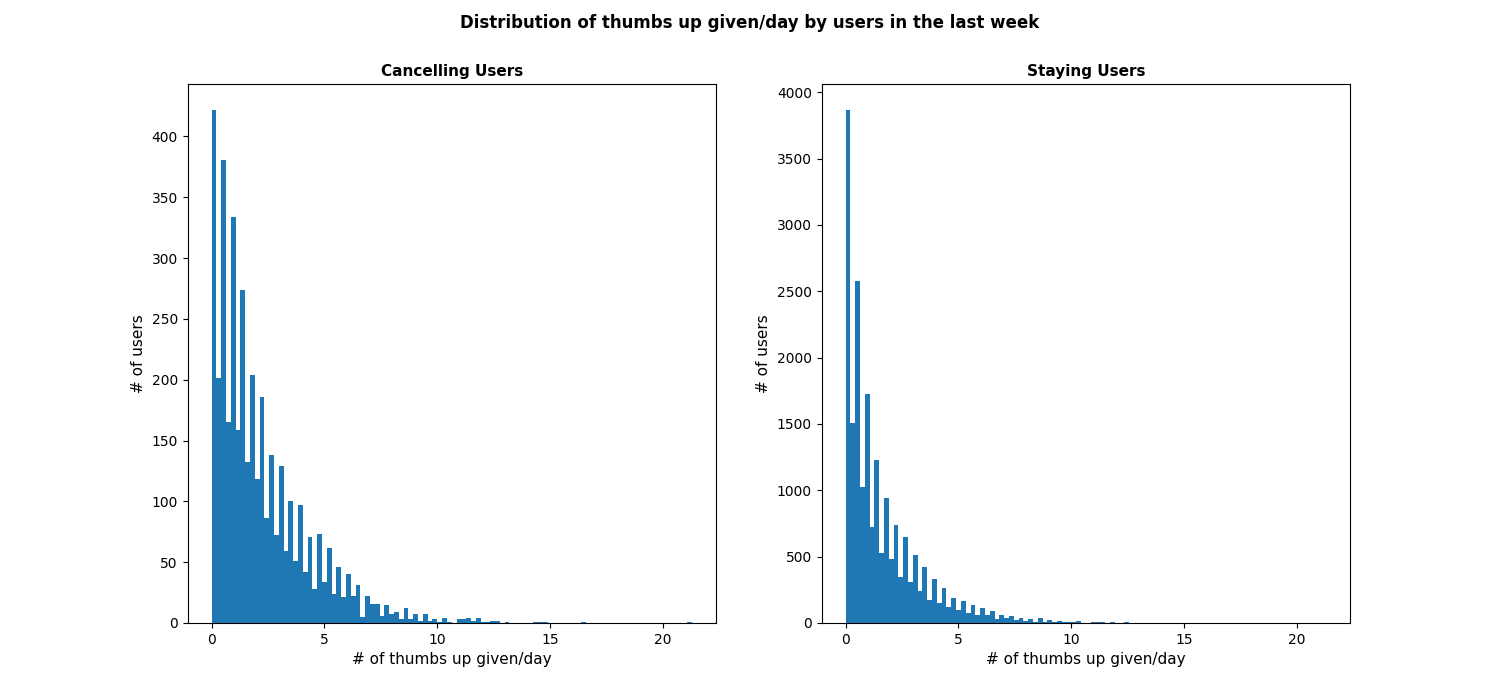

In [75]:
# Plot histogram for thumbs up
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.suptitle('Distribution of thumbs up given/day by users in the last week', fontsize=12, fontweight='bold')
fig.set_figheight(7) 
fig.set_figwidth(15)

ax1.hist(thumbs_up_day_canc_lweek, bins=100)
ax1.set_xlabel('# of thumbs up given/day', fontsize=11)
ax1.set_ylabel('# of users', fontsize=11)
ax1.set_title('Cancelling Users', fontsize=11,fontweight='bold')

ax2.hist(thumbs_up_day_stay_lweek, bins=100)
ax2.set_xlabel('# of thumbs up given/day', fontsize=11)
ax2.set_ylabel('# of users', fontsize=11)
ax2.set_title('Staying Users', fontsize=11,fontweight='bold');

%matplot plt

In [76]:
# Look at the statistics
stats_thumbs_up_canc_lweek = spark.createDataFrame(thumbs_up_day_canc_lweek, FloatType()).describe().collect()
stats_thumbs_up_stay_lweek = spark.createDataFrame(thumbs_up_day_stay_lweek, FloatType()).describe().collect()

print('------------------------------------------------------------------------')
print('Thumbs up given per day statistics for users that cancelled - last week:')
print('Mean = ', '{:.2f}'.format(float(stats_thumbs_up_canc_lweek[1][1])), \
      '; Std. Dev. = ',  '{:.2f}'.format(float(stats_thumbs_up_canc_lweek[2][1])))
print('------------------------------------------------------------------------')
print('Thumbs up given per day statistics for users that stay - last week:')
print('Mean = ', '{:.2f}'.format(float(stats_thumbs_up_stay_lweek[1][1])), \
      '; Std. Dev. = ',  '{:.2f}'.format(float(stats_thumbs_up_stay_lweek[2][1])))
print('------------------------------------------------------------------------')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

------------------------------------------------------------------------
Thumbs up given per day statistics for users that cancelled - last week:
Mean =  2.21 ; Std. Dev. =  2.16
------------------------------------------------------------------------
Thumbs up given per day statistics for users that stay - last week:
Mean =  1.62 ; Std. Dev. =  1.83
------------------------------------------------------------------------

#### 3.2.3. Thumbs down

In [77]:
# Select, for every user that cancelled, the number of thumbs down given and the time window of the analysis
thumbs_dwn_canc = df_user_log_cancelled.\
                groupBy("userId").\
                agg(F.max("data_days"), F.max("total_thumbs_dwn")).collect()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [78]:
# Get the number of thumbs down given, on average
thumbs_dwn_day_canc = [thumbs_given[2]/thumbs_given[1] for thumbs_given in thumbs_dwn_canc]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [79]:
# Select, for every user that is staying, the number of thumbs down given and the time window of the analysis
thumbs_dwn_stay = df_user_log_staying.\
                groupBy("userId").\
                agg(F.max("data_days"), F.max("total_thumbs_dwn")).collect()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [80]:
# Get the number of thumbs down given, on average
thumbs_dwn_day_stay = [thumbs_given[2]/thumbs_given[1] for thumbs_given in thumbs_dwn_stay]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

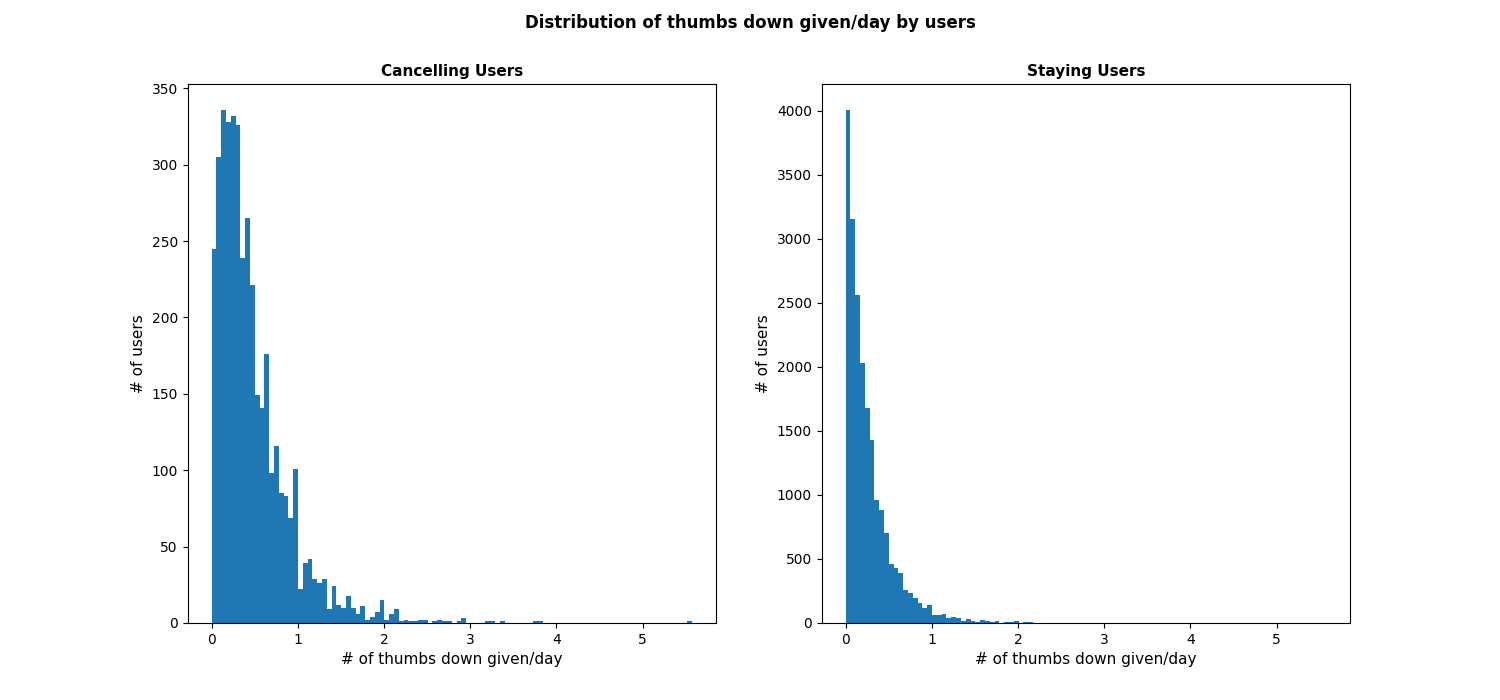

In [81]:
# Plot histogram for thumbs down
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.suptitle('Distribution of thumbs down given/day by users', fontsize=12, fontweight='bold')
fig.set_figheight(7) 
fig.set_figwidth(15)

ax1.hist(thumbs_dwn_day_canc, bins=100)
ax1.set_xlabel('# of thumbs down given/day', fontsize=11)
ax1.set_ylabel('# of users', fontsize=11)
ax1.set_title('Cancelling Users', fontsize=11,fontweight='bold')

ax2.hist(thumbs_dwn_day_stay, bins=100)
ax2.set_xlabel('# of thumbs down given/day', fontsize=11)
ax2.set_ylabel('# of users', fontsize=11)
ax2.set_title('Staying Users', fontsize=11,fontweight='bold');

%matplot plt

In [82]:
# Look at the statistics
stats_thumbs_dwn_canc = spark.createDataFrame(thumbs_dwn_day_canc, FloatType()).describe().collect()
stats_thumbs_dwn_stay = spark.createDataFrame(thumbs_dwn_day_stay, FloatType()).describe().collect()

print('--------------------------------------------------------------')
print('Thumbs down given per day statistics for users that cancelled:')
print('Mean = ', '{:.2f}'.format(float(stats_thumbs_dwn_canc[1][1])), \
      '; Std. Dev. = ',  '{:.2f}'.format(float(stats_thumbs_dwn_canc[2][1])))
print('--------------------------------------------------------------')
print('Thumbs down per day statistics for users that stay:')
print('Mean = ', '{:.2f}'.format(float(stats_thumbs_dwn_stay[1][1])), \
      '; Std. Dev. = ',  '{:.2f}'.format(float(stats_thumbs_dwn_stay[2][1])))
print('--------------------------------------------------------------')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

--------------------------------------------------------------
Thumbs down given per day statistics for users that cancelled:
Mean =  0.48 ; Std. Dev. =  0.43
--------------------------------------------------------------
Thumbs down per day statistics for users that stay:
Mean =  0.27 ; Std. Dev. =  0.29
--------------------------------------------------------------

We can check if anything changes during last week:

In [83]:
# Select, for every user that cancelled, the number of thumbs down given in the last week
thumbs_dwn_canc_lweek = df_user_log_cancelled_lweek.\
                groupBy("userId").\
                agg(F.sum("thumbs_dwn")).collect()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [84]:
# Get the number of thumbs down given per day, on average
thumbs_dwn_day_canc_lweek = [thumbs_given[1]/7 for thumbs_given in thumbs_dwn_canc_lweek]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [85]:
# Select, for every user that is staying, the number of thumbs down given in the last week
thumbs_dwn_stay_lweek = df_user_log_staying_lweek.\
                groupBy("userId").\
                agg(F.sum("thumbs_dwn")).collect()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [86]:
# Get the number of thumbs down given per day, on average
thumbs_dwn_day_stay_lweek = [thumbs_given[1]/7 for thumbs_given in thumbs_dwn_stay_lweek]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

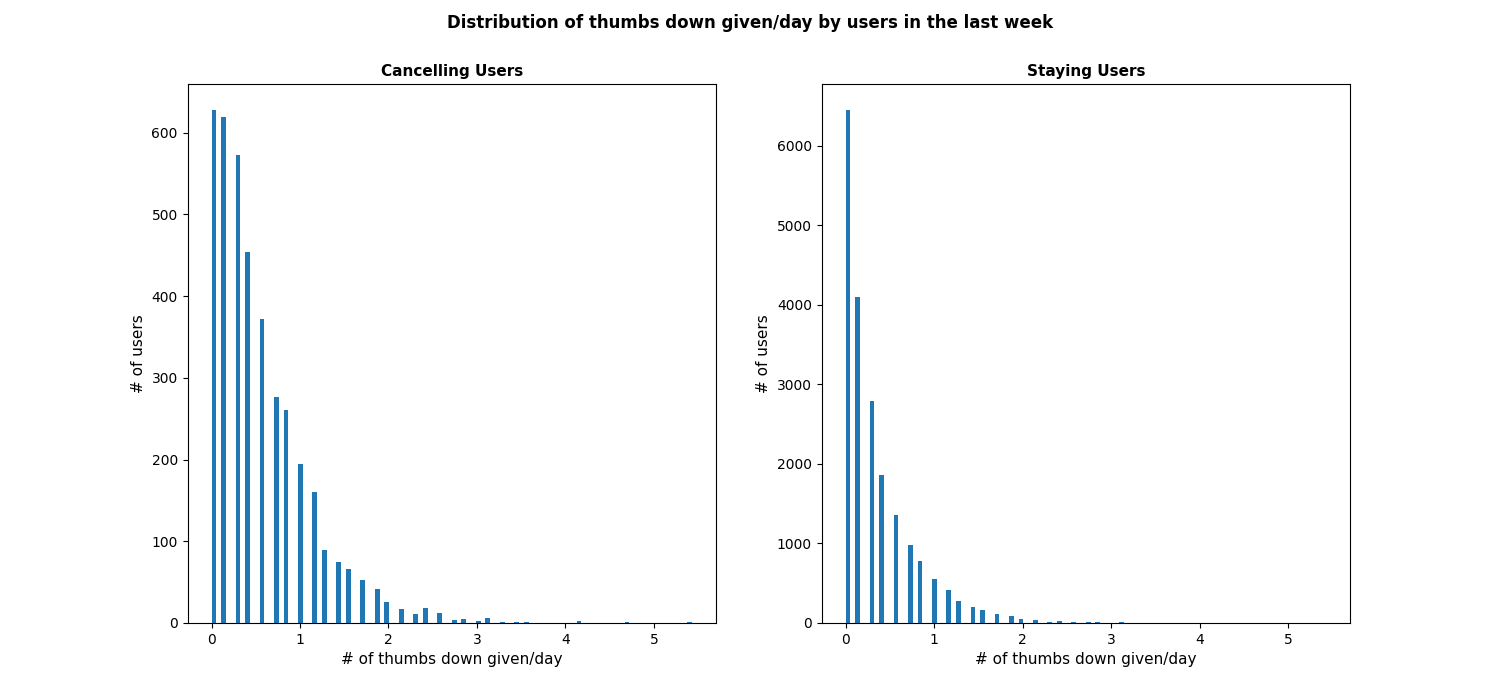

In [87]:
# Plot histogram for thumbs down
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.suptitle('Distribution of thumbs down given/day by users in the last week', fontsize=12, fontweight='bold')
fig.set_figheight(7) 
fig.set_figwidth(15)

ax1.hist(thumbs_dwn_day_canc_lweek, bins=100)
ax1.set_xlabel('# of thumbs down given/day', fontsize=11)
ax1.set_ylabel('# of users', fontsize=11)
ax1.set_title('Cancelling Users', fontsize=11,fontweight='bold')

ax2.hist(thumbs_dwn_day_stay_lweek, bins=100)
ax2.set_xlabel('# of thumbs down given/day', fontsize=11)
ax2.set_ylabel('# of users', fontsize=11)
ax2.set_title('Staying Users', fontsize=11,fontweight='bold');

%matplot plt

In [88]:
# Look at the statistics
stats_thumbs_dwn_canc_lweek = spark.createDataFrame(thumbs_dwn_day_canc_lweek, FloatType()).describe().collect()
stats_thumbs_dwn_stay_lweek = spark.createDataFrame(thumbs_dwn_day_stay_lweek, FloatType()).describe().collect()

print('--------------------------------------------------------------------------')
print('Thumbs down given per day statistics for users that cancelled - last week:')
print('Mean = ', '{:.2f}'.format(float(stats_thumbs_dwn_canc_lweek[1][1])), \
      '; Std. Dev. = ',  '{:.2f}'.format(float(stats_thumbs_dwn_canc_lweek[2][1])))
print('--------------------------------------------------------------------------')
print('Thumbs down given per day statistics for users that stay - last week:')
print('Mean = ', '{:.2f}'.format(float(stats_thumbs_dwn_stay_lweek[1][1])), \
      '; Std. Dev. = ',  '{:.2f}'.format(float(stats_thumbs_dwn_stay_lweek[2][1])))
print('--------------------------------------------------------------------------')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

--------------------------------------------------------------------------
Thumbs down given per day statistics for users that cancelled - last week:
Mean =  0.56 ; Std. Dev. =  0.56
--------------------------------------------------------------------------
Thumbs down given per day statistics for users that stay - last week:
Mean =  0.35 ; Std. Dev. =  0.44
--------------------------------------------------------------------------

### <a class="anchor" id="Upgrade-Downgrade">3.3. Submit an Upgrade/Downgrade request</a>

We can also take a look at how many upgrade/downgrade request can be found in the various datasets, and compare that to the number of users.

In [89]:
# Calculate number of downgrades/upgrades requests for the users that cancelled
downgrade_canc = df_user_log_cancelled.select(F.sum("sub_dwg")).collect()
upgrade_canc = df_user_log_cancelled.select(F.sum("sub_upg")).collect()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [90]:
# Calculate number of downgrades/upgrades requests for the users that are staying
downgrade_stay = df_user_log_staying.select(F.sum("sub_dwg")).collect()
upgrade_stay = df_user_log_staying.select(F.sum("sub_upg")).collect()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [91]:
# Look at the values and the proportions
print('-------------------------------------------------------------')
print('Downgrades/Upgrades requests/number of users that cancelled:')
print('Absolute Downgrades = ', downgrade_canc[0][0])
print('Absolute Upgrades = ', upgrade_canc[0][0])
print('Downgrades/Num. of Users = ', '{:.2f}'.format(downgrade_canc[0][0]/len(users_cancelled)))
print('Upgrades/Num. of Users = ', '{:.2f}'.format(upgrade_canc[0][0]/len(users_cancelled)))
print('-------------------------------------------------------------')
print('Downgrades/Upgrades requests/number of users that stay:')
print('Absolute Downgrades = ', downgrade_stay[0][0])
print('Absolute Upgrades = ', upgrade_stay[0][0])
print('Downgrades/Num. of Users = ', '{:.2f}'.format(downgrade_stay[0][0]/len(users_staying)))
print('Upgrades/Num. of Users = ', '{:.2f}'.format(upgrade_stay[0][0]/len(users_staying)))
print('-------------------------------------------------------------')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

-------------------------------------------------------------
Downgrades/Upgrades requests/number of users that cancelled:
Absolute Downgrades =  1441
Absolute Upgrades =  3438
Downgrades/Num. of Users =  0.36
Upgrades/Num. of Users =  0.87
-------------------------------------------------------------
Downgrades/Upgrades requests/number of users that stay:
Absolute Downgrades =  6408
Absolute Upgrades =  14797
Downgrades/Num. of Users =  0.32
Upgrades/Num. of Users =  0.73
-------------------------------------------------------------

Let's take a look at the last week:

In [92]:
# Calculate number of downgrades/upgrades requests for the users that cancelled - last week of data
downgrade_canc_lweek = df_user_log_cancelled_lweek.select(F.sum("sub_dwg")).collect()
upgrade_canc_lweek = df_user_log_cancelled_lweek.select(F.sum("sub_upg")).collect()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [95]:
# Calculate number of downgrades/upgrades requests for the users that are staying - last week of data
downgrade_stay_lweek = df_user_log_staying_lweek.select(F.sum("sub_dwg")).collect()
upgrade_stay_lweek = df_user_log_staying_lweek.select(F.sum("sub_upg")).collect()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [96]:
# Look at the values and the proportions
print('-----------------------------------------------------------------------------')
print('Downgrades/Upgrades requests for users that cancelled - last week data:')
print('Absolute Downgrades = ', downgrade_canc_lweek[0][0])
print('Absolute Upgrades = ', upgrade_canc_lweek[0][0])
print('Downgrades/Num. of Users = ', '{:.2f}'.format(downgrade_canc_lweek[0][0]/len(users_cancelled_lweek)))
print('Upgrade/Num. of Users = ', '{:.2f}'.format(upgrade_canc_lweek[0][0]/len(users_cancelled_lweek)))
print('-----------------------------------------------------------------------------')
print('Downgrades/Upgrades requests/number of users that stay - last week data:')
print('Absolute Downgrades = ', downgrade_stay_lweek[0][0])
print('Absolute Upgrades = ', upgrade_stay_lweek[0][0])
print('Downgrades/Num. of Users = ', '{:.2f}'.format(downgrade_stay_lweek[0][0]/len(users_staying_lweek)))
print('Upgrade/Num. of Users = ', '{:.2f}'.format(upgrade_stay_lweek[0][0]/len(users_staying_lweek)))
print('-----------------------------------------------------------------------------')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

-----------------------------------------------------------------------------
Downgrades/Upgrades requests for users that cancelled - last week data:
Absolute Downgrades =  357
Absolute Upgrades =  846
Downgrades/Num. of Users =  0.09
Upgrade/Num. of Users =  0.21
-----------------------------------------------------------------------------
Downgrades/Upgrades requests/number of users that stay - last week data:
Absolute Downgrades =  1319
Absolute Upgrades =  2378
Downgrades/Num. of Users =  0.06
Upgrade/Num. of Users =  0.12
-----------------------------------------------------------------------------

### <a class="anchor" id="Roll-Advert">3.4. Roll Advert</a>

In [97]:
# Select, for every user that cancelled, the number of rolled adverts and the time window of the analysis
rolled_advert_canc = df_user_log_cancelled.\
                groupBy("userId").\
                agg(F.max("data_days"), F.max("total_roll_adv")).collect()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [98]:
# Get the rolled advert per day, on average
rolled_advert_day_canc = [rolled_advert[2]/rolled_advert[1] for rolled_advert in rolled_advert_canc]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [99]:
# Select, for every user that is staying, the number of rolled adverts and the time they spent with the service
rolled_advert_stay = df_user_log_staying.\
                groupBy("userId").\
                agg(F.max("data_days"), F.max("total_roll_adv")).collect()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [100]:
# Get the rolled advert per day, on average
rolled_advert_day_stay = [rolled_advert[2]/rolled_advert[1] for rolled_advert in rolled_advert_stay]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

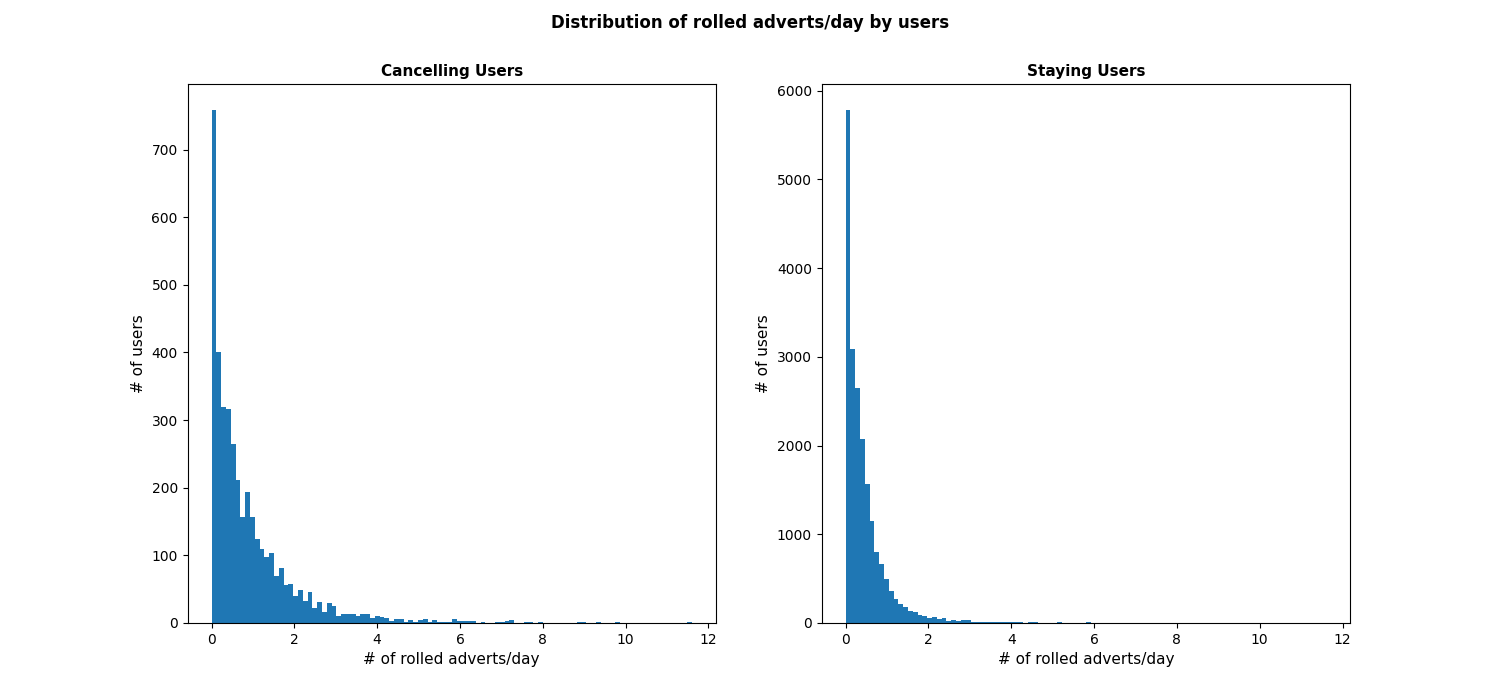

In [101]:
# Plot histogram for rolled advert
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.suptitle('Distribution of rolled adverts/day by users', fontsize=12, fontweight='bold')
fig.set_figheight(7) 
fig.set_figwidth(15)

ax1.hist(rolled_advert_day_canc, bins=100)
ax1.set_xlabel('# of rolled adverts/day', fontsize=11)
ax1.set_ylabel('# of users', fontsize=11)
ax1.set_title('Cancelling Users', fontsize=11,fontweight='bold')

ax2.hist(rolled_advert_day_stay, bins=100)
ax2.set_xlabel('# of rolled adverts/day', fontsize=11)
ax2.set_ylabel('# of users', fontsize=11)
ax2.set_title('Staying Users', fontsize=11,fontweight='bold');

%matplot plt

In [102]:
# Look at the statistics
stats_rolled_advert_day_canc = spark.createDataFrame(rolled_advert_day_canc, FloatType()).describe().collect()
stats_rolled_advert_day_stay = spark.createDataFrame(rolled_advert_day_stay, FloatType()).describe().collect()

print('----------------------------------------------------------')
print('Rolled adverts per day statistics for users that cancelled:')
print('Mean = ', '{:.2f}'.format(float(stats_rolled_advert_day_canc[1][1])), \
      '; Std. Dev. = ',  '{:.2f}'.format(float(stats_rolled_advert_day_canc[2][1])))
print('----------------------------------------------------------')
print('Rolled adverts per day statistics for users that stay:')
print('Mean = ', '{:.2f}'.format(float(stats_rolled_advert_day_stay[1][1])), \
      '; Std. Dev. = ',  '{:.2f}'.format(float(stats_rolled_advert_day_stay[2][1])))
print('----------------------------------------------------------')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

----------------------------------------------------------
Rolled adverts per day statistics for users that cancelled:
Mean =  0.92 ; Std. Dev. =  1.13
----------------------------------------------------------
Rolled adverts per day statistics for users that stay:
Mean =  0.46 ; Std. Dev. =  0.64
----------------------------------------------------------

Here too, we can take a look at what happens focusing on the last week of data:

In [103]:
# Select, for every user that cancelled, the number of rolled adverts in the last week of data
rolled_advert_canc_lweek = df_user_log_cancelled_lweek.\
                groupBy("userId").\
                agg(F.sum("roll_adv")).collect()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [104]:
# Get the rolled advert per day, on average
rolled_advert_day_canc_lweek = [rolled_advert[1]/7 for rolled_advert in rolled_advert_canc_lweek]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [105]:
# Select, for every user that is staying, the number of rolled adverts in the last week of data
rolled_advert_stay_lweek = df_user_log_staying_lweek.\
                groupBy("userId").\
                agg(F.sum("roll_adv")).collect()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [106]:
# Get the rolled advert per day, on average
rolled_advert_day_stay_lweek = [rolled_advert[1]/7 for rolled_advert in rolled_advert_stay_lweek]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

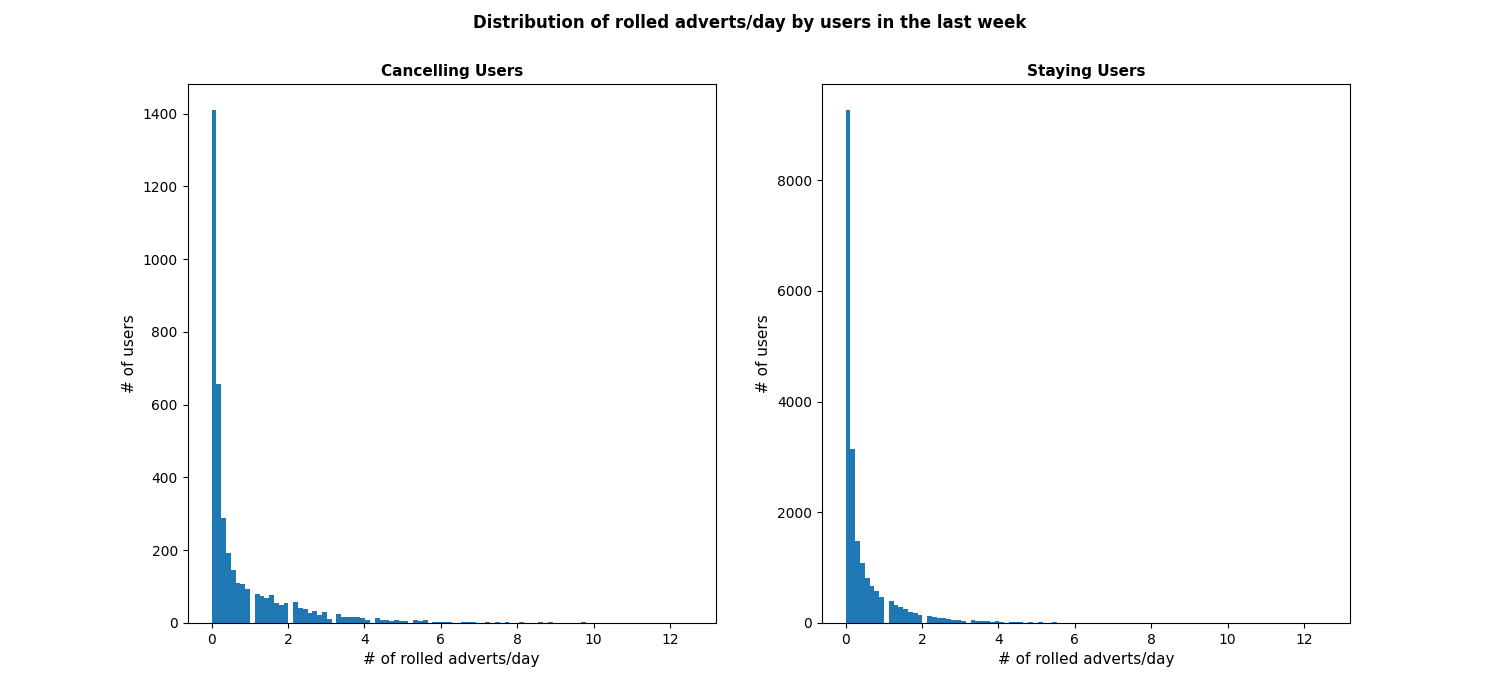

In [107]:
# Plot histogram for rolled advert
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.suptitle('Distribution of rolled adverts/day by users in the last week', fontsize=12, fontweight='bold')
fig.set_figheight(7) 
fig.set_figwidth(15)

ax1.hist(rolled_advert_day_canc_lweek, bins=100)
ax1.set_xlabel('# of rolled adverts/day', fontsize=11)
ax1.set_ylabel('# of users', fontsize=11)
ax1.set_title('Cancelling Users', fontsize=11,fontweight='bold')

ax2.hist(rolled_advert_day_stay_lweek, bins=100)
ax2.set_xlabel('# of rolled adverts/day', fontsize=11)
ax2.set_ylabel('# of users', fontsize=11)
ax2.set_title('Staying Users', fontsize=11,fontweight='bold');

%matplot plt

In [108]:
# Look at the statistics
stats_rolled_advert_day_canc_lweek = spark.createDataFrame(rolled_advert_day_canc_lweek, FloatType()).describe().collect()
stats_rolled_advert_day_stay_lweek = spark.createDataFrame(rolled_advert_day_stay_lweek, FloatType()).describe().collect()

print('-----------------------------------------------------------------------')
print('Rolled adverts per day statistics for users that cancelled - last week:')
print('Mean = ', '{:.2f}'.format(float(stats_rolled_advert_day_canc_lweek[1][1])), \
      '; Std. Dev. = ',  '{:.2f}'.format(float(stats_rolled_advert_day_canc_lweek[2][1])))
print('-----------------------------------------------------------------------')
print('Rolled adverts per day statistics for users that stay - last week:')
print('Mean = ', '{:.2f}'.format(float(stats_rolled_advert_day_stay_lweek[1][1])), \
      '; Std. Dev. = ',  '{:.2f}'.format(float(stats_rolled_advert_day_stay_lweek[2][1])))
print('-----------------------------------------------------------------------')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

-----------------------------------------------------------------------
Rolled adverts per day statistics for users that cancelled - last week:
Mean =  0.79 ; Std. Dev. =  1.33
-----------------------------------------------------------------------
Rolled adverts per day statistics for users that stay - last week:
Mean =  0.46 ; Std. Dev. =  0.86
-----------------------------------------------------------------------

### <a class="anchor" id="Demographics">3.5. Demographics</a>

As a final look at the data, we can explore the demographics of the users, in terms of gender or location:

In [109]:
# Parse the cancelled users to collect their gender
canc_user_gender = df_user_log_cancelled.\
                groupBy("userId").\
                agg(F.first("gender", True)).collect()

# Convert to list
canc_user_gender_list = [canc_user[1] for canc_user in canc_user_gender]

# Count males/females
num_canc_male_users = sum([user == 'M' for user in canc_user_gender_list])
num_canc_female_users = sum([user == 'F' for user in canc_user_gender_list])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [110]:
# Parse the staying users to collect their gender
staying_user_gender = df_user_log_staying.\
                groupBy("userId").\
                agg(F.first("gender", True)).collect()

# Convert to list
staying_user_gender_list = [canc_user[1] for canc_user in staying_user_gender]

# Count males/females
num_staying_male_users = sum([user == 'M' for user in staying_user_gender_list])
num_staying_female_users = sum([user == 'F' for user in staying_user_gender_list])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [111]:
# Look at the values and the proportions
print('-----------------------------------------------------------------------------')
print('Gender distribution for users that cancelled:')
print('Number of male users = ', num_canc_male_users)
print('Number of female users = ', num_canc_female_users)
print('Number of male users/Total Users = ', '{:.2f}'.format(num_canc_male_users/len(users_cancelled)))
print('Number of female users/Total Users = ', '{:.2f}'.format(num_canc_female_users/len(users_cancelled_lweek)))
print('-----------------------------------------------------------------------------')
print('Gender distribution for users that stay:')
print('Number of male users = ', num_staying_male_users)
print('Number of female users = ', num_staying_female_users)
print('Number of male users/Total Users = ', '{:.2f}'.format(num_staying_male_users/len(users_staying)))
print('Number of female users/Total Users = ', '{:.2f}'.format(num_staying_female_users/len(users_staying)))
print('-----------------------------------------------------------------------------')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

-----------------------------------------------------------------------------
Gender distribution for users that cancelled:
Number of male users =  2123
Number of female users =  1848
Number of male users/Total Users =  0.53
Number of female users/Total Users =  0.47
-----------------------------------------------------------------------------
Gender distribution for users that stay:
Number of male users =  10641
Number of female users =  9662
Number of male users/Total Users =  0.52
Number of female users/Total Users =  0.48
-----------------------------------------------------------------------------

In [118]:
# Parse the cancelled users to collect their location
canc_user_location = df_user_log_cancelled.\
                filter(df_user_log_cancelled["location"] != "").\
                groupBy("userId").\
                agg(F.first("location", True)).collect()

# Get the state only
canc_user_state = [user_loc[1].split(', ')[1] for user_loc in canc_user_location]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [117]:
# Parse the staying users to collect their location
staying_user_location = df_user_log_staying.\
                filter(df_user_log_staying["location"] != "").\
                groupBy("userId").\
                agg(F.first("location")).collect()

# Get the state only
staying_user_state = [user_loc[1].split(', ')[1] for user_loc in staying_user_location]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

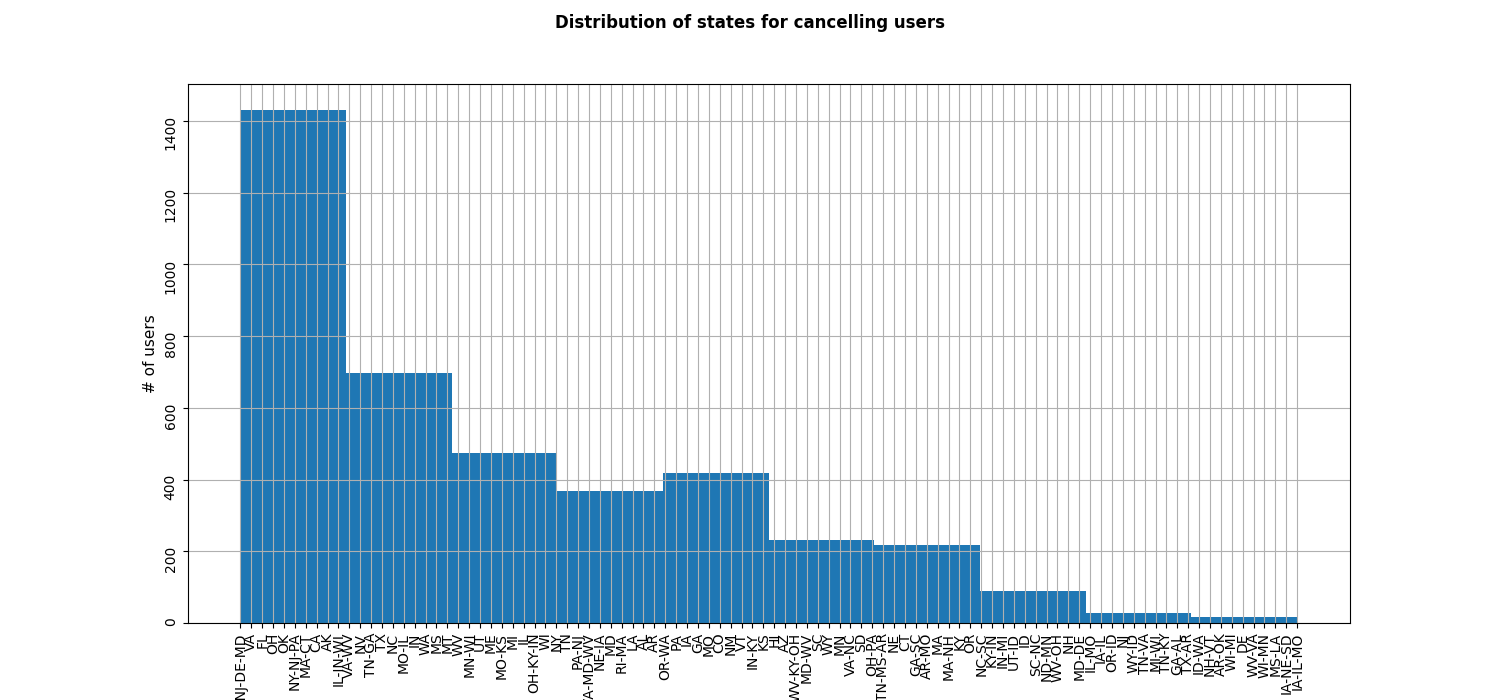

In [119]:
# Plot histogram for state location (1/2)
fig, ax = plt.subplots(1, 1)

fig.suptitle('Distribution of states for cancelling users', fontsize=12, fontweight='bold')
fig.set_figheight(7) 
fig.set_figwidth(15)

ax.hist(canc_user_state)
ax.set_xlabel('States', fontsize=11)
ax.set_ylabel('# of users', fontsize=11)
# plt.set_title('Cancelling Users', fontsize=11,fontweight='bold')
ax.tick_params(labelrotation = 90)
ax.grid()

%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

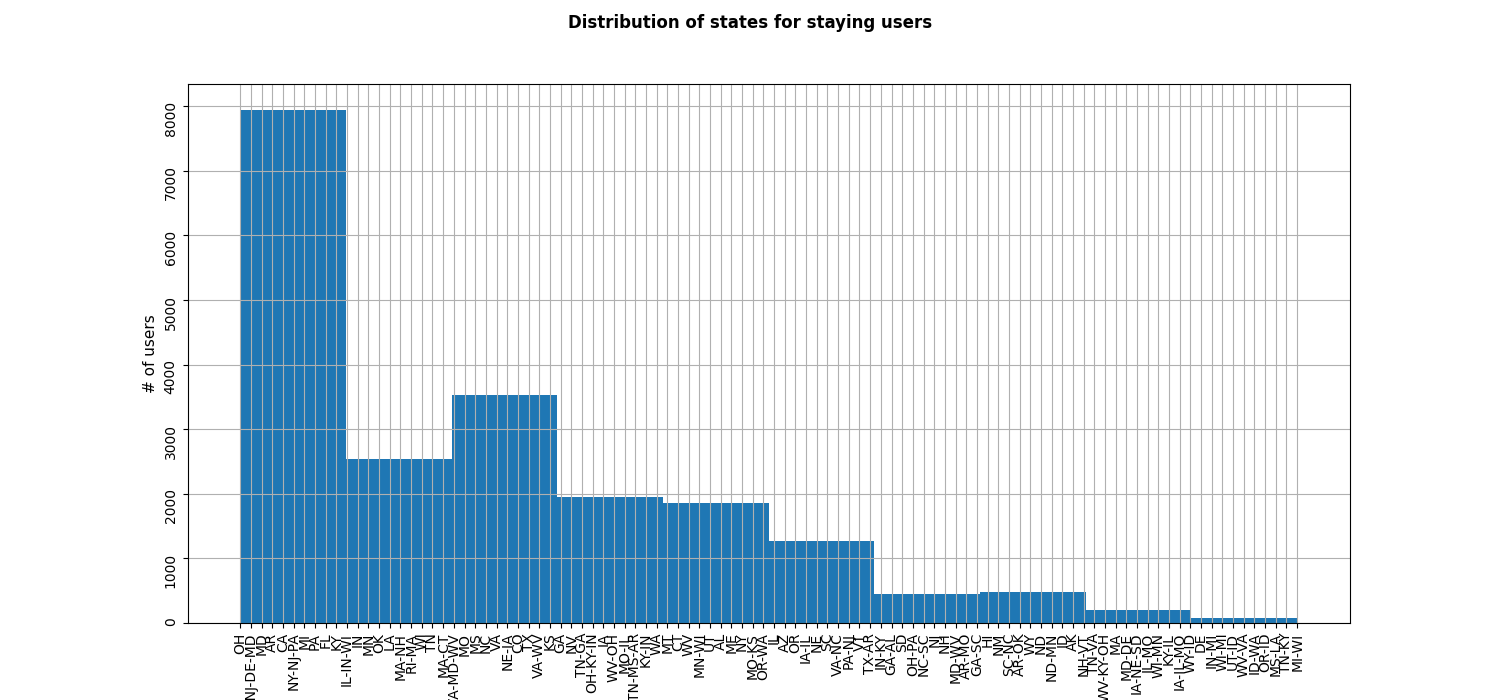

In [120]:
# Plot histogram for state location (2/2)
fig, ax = plt.subplots(1, 1)

fig.suptitle('Distribution of states for staying users', fontsize=12, fontweight='bold')
fig.set_figheight(7) 
fig.set_figwidth(15)

ax.hist(staying_user_state)
ax.set_ylabel('# of users', fontsize=11)
ax.tick_params(labelrotation = 90)
ax.set_xlabel('States', fontsize=11)
ax.grid()

%matplot plt